In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [2]:
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [3]:
df_DA = df[df['job_title_short'] == 'Data Analyst'].copy()

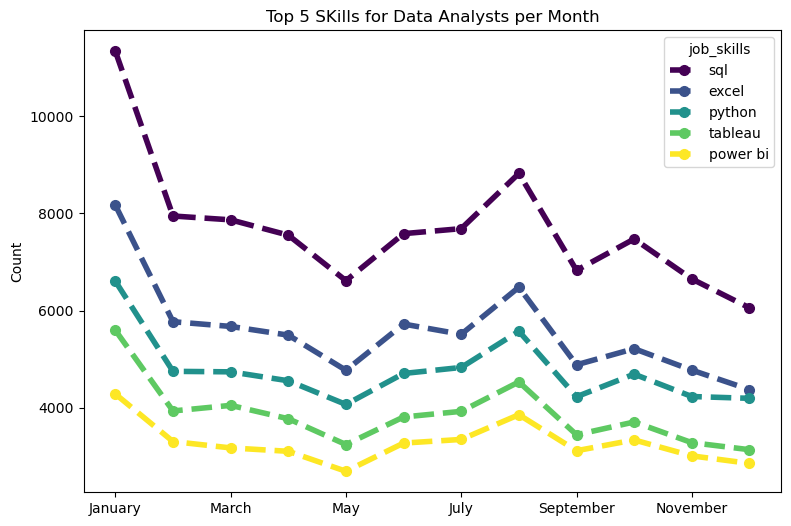

In [18]:
# Create new column for month number
df_DA['job_posted_month_no'] = df_DA['job_posted_date'].dt.month

# Explode the job_skills column and pivot
df_DA_explode = df_DA.explode('job_skills')
df_DA_pivot = df_DA_explode.pivot_table(index='job_posted_month_no', columns='job_skills', aggfunc='size', fill_value=0)

# Sort the skills by count
df_DA_pivot.loc['Total'] = df_DA_pivot.sum()
df_DA_pivot = df_DA_pivot[df_DA_pivot.loc['Total'].sort_values(ascending=False).index]
df_DA_pivot = df_DA_pivot.drop('Total')

# Use month names for plotting
df_DA_pivot = df_DA_pivot.reset_index()
df_DA_pivot['job_posted_month'] = df_DA_pivot['job_posted_month_no'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%B'))
df_DA_pivot = df_DA_pivot.set_index('job_posted_month')
df_DA_pivot = df_DA_pivot.drop(columns='job_posted_month_no')

# Plot top 4 skills for data analysts
df_DA_pivot.iloc[:, :5].plot(
    kind='line',
    linewidth=4,
    linestyle='--',
    colormap='viridis',
    marker='o',
    markersize=7,
    figsize=(9,6)
    )
plt.title('Top 5 SKills for Data Analysts per Month')
plt.ylabel('Count')
plt.xlabel('')
plt.show()

In [41]:
# Explode the job skills into individual rows
df_exploded = df.explode('job_skills')

# Calculate the average salary and count of job postings per skill
skill_stats = df_exploded.groupby('job_skills').agg(
    skill_count=("job_skills", "count"),
    median_salary=('salary_year_avg', 'median')
)

# Limit to top 20 skills
skill_count = 20

skill_stats = skill_stats.sort_values(by='skill_count', ascending=False).head(skill_count)

skill_stats

,skill_count,median_salary
job_skills,,
sql,384849,120000.0
python,380909,125000.0
aws,145381,135000.0
azure,132527,125000.0
r,130892,119550.0
tableau,127213,111175.0
excel,127018,92500.0
spark,114609,140000.0
power bi,98147,102000.0


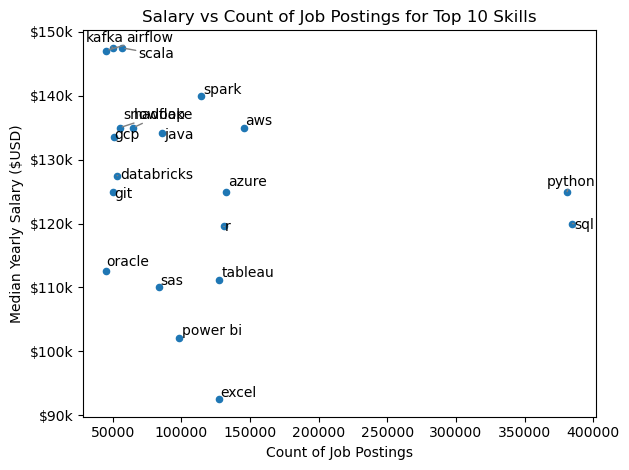

In [45]:
from adjustText import adjust_text

skill_stats.plot(kind='scatter', x='skill_count', y= 'median_salary')

text = []
for i, txt in enumerate(skill_stats.index):
    text.append(plt.text(skill_stats['skill_count'].iloc[i], skill_stats['median_salary'].iloc[i], txt))

adjust_text(text, arrowprops=dict(arrowstyle="-", color='gray', lw=1.0))

ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}k' ))

plt.xlabel('Count of Job Postings')
plt.ylabel('Median Yearly Salary ($USD)')
plt.title('Salary vs Count of Job Postings for Top 10 Skills')

plt.tight_layout()
plt.show()